<a href="https://colab.research.google.com/github/Gruz77/Deep-Learning-in-Finance/blob/main/Volatility_Prediction/Volatility_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Volatility Prediction <center/>
---
---

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.special as scsp
from tqdm.notebook import tqdm
plt.style.use("ggplot")

In [ ]:
# Import de nos drive pour les fichiers
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# 1 - Model

# 1.1 - Rough Volatility

- This part is a Python 3 adaptation of the code in the following link: https://tpq.io/p/rough_volatility_with_python.html

In [ ]:
data = pd.read_parquet('.../oxfordmanrealizedvolatilityindices.parquet')
data

# data.set_index("index", inplace=True)

# data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks Centrale/Deep Learning in Finance/TP5_PredVol/oxfordmanrealizedvolatilityindices.csv.gz", index_col=0, parse_dates=True)
# # data.set_index("index", inplace=True)
# data


,Symbol,close_price,open_to_close,medrv,rsv,rv5,rv10_ss,rv5_ss,bv_ss,rk_twoscale,open_price,bv,open_time,rv10,rk_parzen,close_time,rk_th2,rsv_ss,nobs
2000-01-03 00:00:00+00:00,.AEX,675.44,-0.000340,0.000050,0.000046,0.000130,0.000178,0.000130,0.000100,0.000103,675.67,0.000100,90101.0,0.000178,0.000179,163015.0,0.000102,0.000046,1795.0
2000-01-04 00:00:00+00:00,.AEX,642.25,-0.033606,0.000075,0.000147,0.000201,0.000261,0.000201,0.000207,0.000199,664.20,0.000207,90416.0,0.000261,0.000423,163016.0,0.000201,0.000147,1785.0
2000-01-05 00:00:00+00:00,.AEX,632.31,-0.001675,0.000166,0.000328,0.000491,0.000714,0.000491,0.000361,0.000325,633.37,0.000361,90016.0,0.000714,0.000324,163016.0,0.000345,0.000328,1801.0
2000-01-06 00:00:00+00:00,.AEX,624.21,-0.013130,0.000152,0.000116,0.000225,0.000182,0.000225,0.000258,0.000218,632.46,0.000258,90016.0,0.000182,0.000219,163002.0,0.000221,0.000116,1799.0
2000-01-07 00:00:00+00:00,.AEX,644.86,0.025013,0.000039,0.000048,0.000138,0.000157,0.000138,0.000130,0.000126,628.93,0.000130,90046.0,0.000157,0.000155,163016.0,0.000123,0.000048,1798.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11 00:00:00+00:00,.STOXX50E,3668.43,0.003848,0.000013,0.000014,0.000028,0.000021,0.000028,0.000027,0.000032,3654.34,0.000027,90015.0,0.000021,0.000009,173015.0,0.000033,0.000014,4255.0
2021-02-12 00:00:00+00:00,.STOXX50E,3695.01,0.007053,0.000014,0.000014,0.000031,0.000036,0.000031,0.000032,0.000031,3669.04,0.000032,90015.0,0.000036,0.000026,173002.0,0.000032,0.000014,4157.0
2021-02-15 00:00:00+00:00,.STOXX50E,3738.69,0.007340,0.000008,0.000006,0.000024,0.000021,0.000024,0.000021,0.000020,3711.35,0.000021,90015.0,0.000021,0.000016,173001.0,0.000021,0.000006,4236.0
2021-02-16 00:00:00+00:00,.STOXX50E,3725.56,-0.002673,0.000012,0.000013,0.000026,0.000026,0.000026,0.000026,0.000028,3735.53,0.000026,90015.0,0.000026,0.000010,173002.0,0.000028,0.000013,4224.0


- With:
  - bv :	Bipower Variation (5-min)
  - bv_ss :	Bipower Variation (5-min Sub-sampled)
  - close_price :	Closing (Last) Price
  - close_time :	Closing Time
  - medrv	: Median Realized Variance (5-min)
  - nobs	: Number of Observations
  - open_price : Opening (First) Price
  - open_time	: Opening Time
  - open_to_close	: Open to Close Return
  - rk_parzen	: Realized Kernel Variance (Non-Flat Parzen)
  - rk_th2 : Realized Kernel Variance (Tukey-Hanning(2))
  - rk_twoscale	: Realized Kernel Variance (Two-Scale/Bartlett)
  - rsv	: Realized Semi-variance (5-min)
  - rsv_ss	: Realized Semi-variance (5-min Sub-sampled)
  - rv10 : Realized Variance (10-min)
  - rv10_ss	: Realized Variance (10-min Sub-sampled)
  - rv5	: Realized Variance (5-min)
  - rv5_ss : Realized Variance (5-min Sub-sampled)

With $$Semivariance = \frac{1}{n}∑\limits^{n}_{r_t < Average}(Average - r_t)^{2}$$

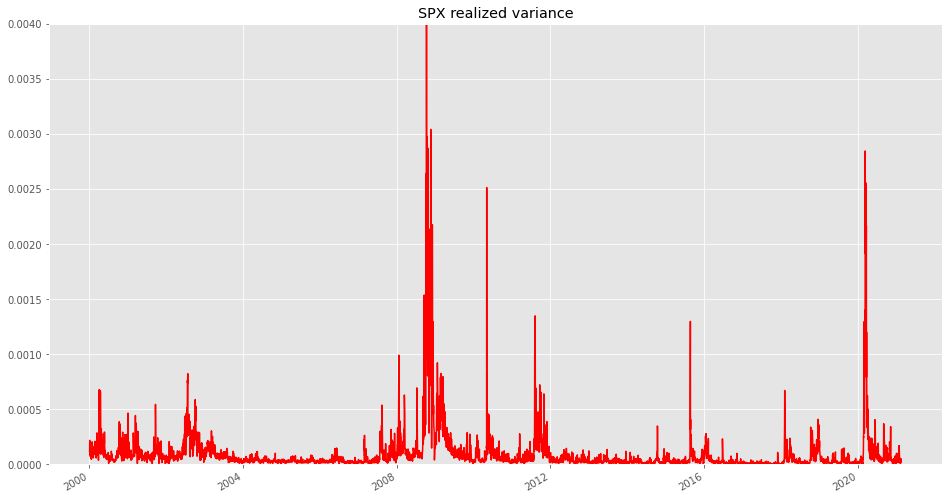

In [ ]:
spx = data[data["Symbol"] == ".SPX"]
spx["rk_twoscale"].plot(color='red', grid=True, title='SPX realized variance',
         figsize=(16, 9), ylim=(0,0.004));

In [ ]:
%%capture
spx['sqrt']= np.sqrt(spx['rk_twoscale'])
spx['log_sqrt'] = np.log(spx['sqrt'])

def del_Raw(q, x): 
    """ Scaling of m(q,Delta) avec lag Delta"""
    return [np.mean(np.abs(spx['log_sqrt'] - spx['log_sqrt'].shift(lag)) ** q) for lag in x]

[0.08495158289730485, 0.16930164043370957, 0.25320521325596695, 0.3368248767606616, 0.5034614329671553]


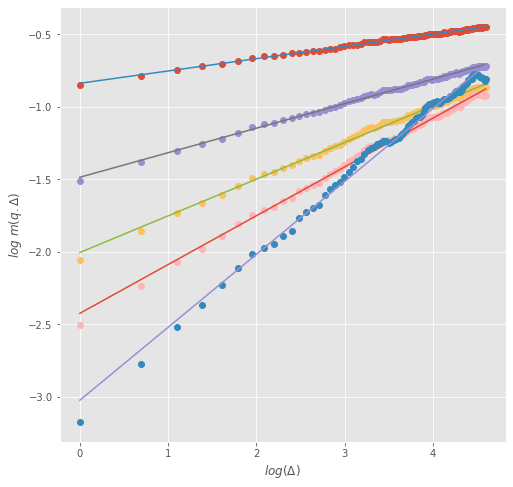

In [ ]:
plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o') 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    
print(zeta_q)

0.1679046908824655


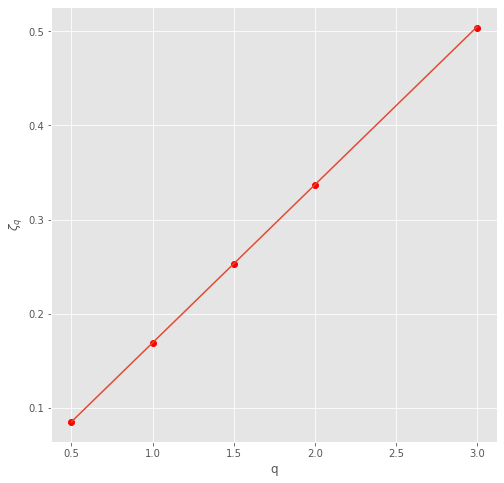

In [ ]:
plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec + line[1])
h_est= line[0]
print(h_est)

In [ ]:
def dlsig2(sig, x, pr=False):
    if pr:
        a = np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a = a ** 2
        print(a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

In [ ]:
h = list() # coeffs hurst
nu = list() # variance estimation

for mysymbol in data["Symbol"].unique():
    sig = data[data["Symbol"]==mysymbol]["rk_twoscale"]
    sig = np.log(np.sqrt(sig))
    sig = sig.dropna()
    model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
    nu.append(np.sqrt(np.exp(model[1])))
    h.append(model[0]/2.)
    
OxfordH = pd.DataFrame({'Symbol':data["Symbol"].unique(), 'h_est': h, 'nu_est': nu})

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Variances forecasts

In [ ]:
import pdb

def c_tilde(h):
    return scsp.gamma(3. / 2. - h) / scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h)

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = pd.DataFrame(rvdata.truncate(after=date))

    l = len(ldata)
    ldata = np.log(ldata[l - nLags:])

    ldata['cf'] = np.fliplr([cf])[0]
    # print ldata
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / sum(ldata['cf'])    
    return math.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))

In [ ]:
mysymbol=".SPX"

rvdata=data[data["Symbol"]==mysymbol]["rk_twoscale"]

In [ ]:
fit_symbol = OxfordH[OxfordH["Symbol"]==mysymbol]
nu  = fit_symbol['nu_est'] # Vol of vol estimate for SPX
h = fit_symbol["h_est"].values
n = len(rvdata)
delta = 1
nLags = 5
dates = rvdata.iloc[nLags:n-delta].index

In [ ]:
delta = 1
nLags = 500
dates = rvdata.iloc[nLags:n-delta].index
rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,delta=delta, nu=nu) for d in dates]
rv_actual = rvdata.iloc[nLags+delta:n].values

In [ ]:
vol_actual = np.sqrt(rv_actual*252)
vol_predict = np.sqrt(np.array(rv_predict)*252)

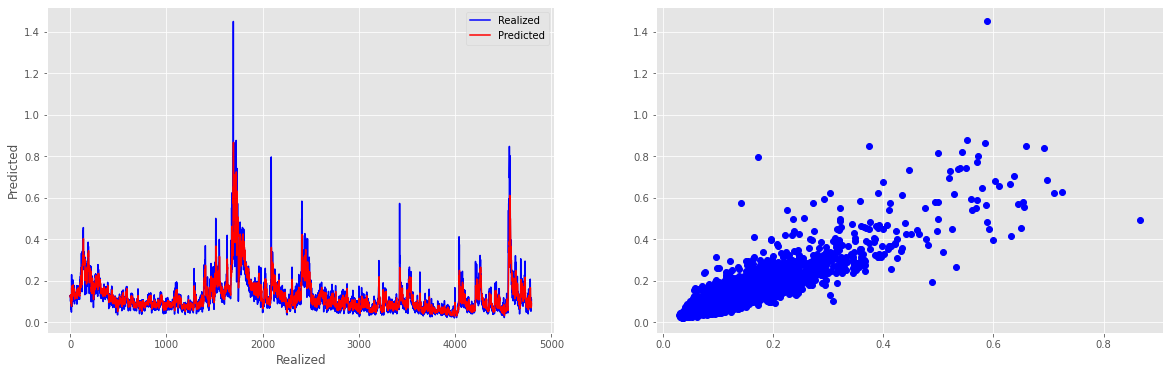

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].set(xlabel="Points", ylabel="Annualized vol")
ax[0].set(xlabel="Realized", ylabel="Predicted")
ax[0].plot(vol_actual, "b", label="Realized")
ax[0].plot(vol_predict, "r", label="Predicted");
ax[1].plot(vol_predict, vol_actual, 'bo');
ax[0].legend();

## Hurst coefficient estimation

In [ ]:
print('le coefficient de Hurst vaut :',h)

le coefficient de Hurst vaut : [0.16841244]


The Hurst coefficient is 0.168 which is a usual value for a financial volatility series.

## The flight forecast is stored in a file for later use

- It is important to note that it is not the annualised flight that is stored but the predicted variance "rv_predict".

In [ ]:
pd.DataFrame(rv_predict).to_csv(".../Predicted_vol_1.1.csv", index=False, header=False)

# 2 - Forecasting with Deep Learning

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

# gpu_devices = tf.config.experimental.list_physical_devices('GPU')  # allow memory use to grow
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

In [ ]:
from keras.models import Sequential,Model
from keras.layers import Input, Dense, LSTM, GRU, Activation, Reshape, Flatten, Dropout, Lambda, RepeatVector
from keras.layers import Add,Multiply
from keras.layers import BatchNormalization
from keras.layers import UpSampling1D, Conv1D
from keras.layers import LeakyReLU

In [ ]:
spx

,Symbol,close_price,open_to_close,medrv,rsv,rv5,rv10_ss,rv5_ss,bv_ss,rk_twoscale,open_price,bv,open_time,rv10,rk_parzen,close_time,rk_th2,rsv_ss,nobs,sqrt,log_sqrt
2000-01-03 00:00:00+00:00,.SPX,1454.24,-0.011602,0.000058,0.000096,0.000141,0.000164,0.000141,0.000141,0.000122,1471.21,0.000141,83004.0,0.000164,0.000340,145959.0,0.000130,0.000096,1554.0,0.011033,-4.506843
2000-01-04 00:00:00+00:00,.SPX,1399.02,-0.035102,0.000067,0.000180,0.000224,0.000295,0.000224,0.000173,0.000142,1449.00,0.000173,83009.0,0.000295,0.000215,150000.0,0.000162,0.000180,1564.0,0.011930,-4.428714
2000-01-05 00:00:00+00:00,.SPX,1402.09,0.004625,0.000142,0.000131,0.000314,0.000267,0.000314,0.000303,0.000219,1395.62,0.000303,83012.0,0.000267,0.000163,150003.0,0.000240,0.000131,1552.0,0.014800,-4.213107
2000-01-06 00:00:00+00:00,.SPX,1403.06,0.002991,0.000070,0.000056,0.000131,0.000115,0.000131,0.000128,0.000127,1398.87,0.000128,83005.0,0.000115,0.000067,145954.0,0.000132,0.000056,1561.0,0.011251,-4.487290
2000-01-07 00:00:00+00:00,.SPX,1440.84,0.026293,0.000049,0.000023,0.000094,0.000121,0.000094,0.000079,0.000091,1403.45,0.000079,83000.0,0.000121,0.000215,150000.0,0.000095,0.000023,1540.0,0.009535,-4.652832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-10 00:00:00+00:00,.SPX,3910.02,-0.002748,0.000018,0.000050,0.000078,0.000054,0.000078,0.000077,0.000055,3920.78,0.000077,83001.0,0.000054,0.000065,150001.0,0.000053,0.000050,23401.0,0.007407,-4.905287
2021-02-11 00:00:00+00:00,.SPX,3916.28,-0.000031,0.000015,0.000026,0.000043,0.000042,0.000043,0.000033,0.000032,3916.40,0.000033,83001.0,0.000042,0.000033,150001.0,0.000031,0.000026,23401.0,0.005645,-5.177072
2021-02-12 00:00:00+00:00,.SPX,3935.07,0.005969,0.000007,0.000004,0.000015,0.000012,0.000015,0.000014,0.000013,3911.65,0.000014,83001.0,0.000012,0.000017,150001.0,0.000013,0.000004,23401.0,0.003573,-5.634475
2021-02-16 00:00:00+00:00,.SPX,3932.25,-0.001870,0.000016,0.000023,0.000042,0.000030,0.000042,0.000041,0.000032,3939.61,0.000041,83001.0,0.000030,0.000018,150000.0,0.000032,0.000023,23400.0,0.005690,-5.168998


- Functions to transform our features into the 3D input matrix of the LSTM.

In [ ]:
#split a univariate sequence into samples
def split_sequence_univariate(sequence, n_steps):
    """ Pour transformer un array 1D en 3D"""
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

## 1) Predictor matrix without flight prediction from models

- We will estimate the log variance, as in the previous section. 

In [ ]:
X_full_log = np.log(spx[["rk_twoscale"]].values)  

- We use the function to have our dataset in 3D input format for the LSTM.

In [ ]:
N_I = 100 # Input sequence length
X_sample,y_sample=split_sequence_univariate(X_full_log, N_I) 
pd.DataFrame(X_sample.reshape(X_sample.shape[0], X_sample.shape[1]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-9.013685,-8.857427,-8.426213,-8.974581,-9.305664,-9.155427,-9.535343,-9.109009,-9.358711,-9.422623,-9.537633,-9.904076,-9.147005,-9.904493,-8.922844,-8.859772,-9.502663,-8.915450,-8.491714,-8.681621,-9.033426,-8.817958,-8.953030,-9.635946,-9.621037,-9.712135,-9.197438,-9.093327,-9.217012,-9.303124,-9.132378,-9.216386,-8.721937,-8.931130,-8.771781,-9.055697,-8.470310,-8.665389,-8.618127,-9.210345,...,-8.454897,-8.541160,-8.376927,-7.295877,-7.725891,-8.622939,-9.203708,-9.024197,-8.374678,-9.011034,-8.145206,-7.306642,-7.334833,-8.223146,-8.534250,-9.282389,-8.036063,-8.908287,-9.008127,-8.175250,-9.142083,-9.049544,-8.943677,-8.651940,-8.845353,-8.985020,-9.046932,-8.860779,-8.404084,-8.985739,-9.412004,-9.362600,-8.518716,-8.951772,-9.656680,-8.999254,-8.194818,-8.555588,-8.130511,-8.649147
1,-8.857427,-8.426213,-8.974581,-9.305664,-9.155427,-9.535343,-9.109009,-9.358711,-9.422623,-9.537633,-9.904076,-9.147005,-9.904493,-8.922844,-8.859772,-9.502663,-8.915450,-8.491714,-8.681621,-9.033426,-8.817958,-8.953030,-9.635946,-9.621037,-9.712135,-9.197438,-9.093327,-9.217012,-9.303124,-9.132378,-9.216386,-8.721937,-8.931130,-8.771781,-9.055697,-8.470310,-8.665389,-8.618127,-9.210345,-9.190616,...,-8.541160,-8.376927,-7.295877,-7.725891,-8.622939,-9.203708,-9.024197,-8.374678,-9.011034,-8.145206,-7.306642,-7.334833,-8.223146,-8.534250,-9.282389,-8.036063,-8.908287,-9.008127,-8.175250,-9.142083,-9.049544,-8.943677,-8.651940,-8.845353,-8.985020,-9.046932,-8.860779,-8.404084,-8.985739,-9.412004,-9.362600,-8.518716,-8.951772,-9.656680,-8.999254,-8.194818,-8.555588,-8.130511,-8.649147,-8.798241
2,-8.426213,-8.974581,-9.305664,-9.155427,-9.535343,-9.109009,-9.358711,-9.422623,-9.537633,-9.904076,-9.147005,-9.904493,-8.922844,-8.859772,-9.502663,-8.915450,-8.491714,-8.681621,-9.033426,-8.817958,-8.953030,-9.635946,-9.621037,-9.712135,-9.197438,-9.093327,-9.217012,-9.303124,-9.132378,-9.216386,-8.721937,-8.931130,-8.771781,-9.055697,-8.470310,-8.665389,-8.618127,-9.210345,-9.190616,-9.340817,...,-8.376927,-7.295877,-7.725891,-8.622939,-9.203708,-9.024197,-8.374678,-9.011034,-8.145206,-7.306642,-7.334833,-8.223146,-8.534250,-9.282389,-8.036063,-8.908287,-9.008127,-8.175250,-9.142083,-9.049544,-8.943677,-8.651940,-8.845353,-8.985020,-9.046932,-8.860779,-8.404084,-8.985739,-9.412004,-9.362600,-8.518716,-8.951772,-9.656680,-8.999254,-8.194818,-8.555588,-8.130511,-8.649147,-8.798241,-9.308414
3,-8.974581,-9.305664,-9.155427,-9.535343,-9.109009,-9.358711,-9.422623,-9.537633,-9.904076,-9.147005,-9.904493,-8.922844,-8.859772,-9.502663,-8.915450,-8.491714,-8.681621,-9.033426,-8.817958,-8.953030,-9.635946,-9.621037,-9.712135,-9.197438,-9.093327,-9.217012,-9.303124,-9.132378,-9.216386,-8.721937,-8.931130,-8.771781,-9.055697,-8.470310,-8.665389,-8.618127,-9.210345,-9.190616,-9.340817,-9.554475,...,-7.295877,-7.725891,-8.622939,-9.203708,-9.024197,-8.374678,-9.011034,-8.145206,-7.306642,-7.334833,-8.223146,-8.534250,-9.282389,-8.036063,-8.908287,-9.008127,-8.175250,-9.142083,-9.049544,-8.943677,-8.651940,-8.845353,-8.985020,-9.046932,-8.860779,-8.404084,-8.985739,-9.412004,-9.362600,-8.518716,-8.951772,-9.656680,-8.999254,-8.194818,-8.555588,-8.130511,-8.649147,-8.798241,-9.308414,-8.968436
4,-9.305664,-9.155427,-9.535343,-9.109009,-9.358711,-9.422623,-9.537633,-9.904076,-9.147005,-9.904493,-8.922844,-8.859772,-9.502663,-8.915450,-8.491714,-8.681621,-9.033426,-8.817958,-8.953030,-9.635946,-9.621037,-9.712135,-9.197438,-9.093327,-9.217012,-9.303124,-9.132378,-9.216386,-8.721937,-8.931130,-8.771781,-9.055697,-8.470310,-8.665389,-8.618127,-9.210345,-9.190616,-9.340817,-9.554475,-9.739613,...,-7.725891,-8.622939,-9.203708,-9.024197,-8.374678,-9.011034,-8.145206,-7.306642,-7.334833,-8.223146,-8.534250,-9.282389,-8.036063,-8.90

## 2) LSTM for forecasting

- Here are the parameters: 
  - T_in: Length of data in the train window
  - dT: Number of points between calibration (number of points predicted by the network after each training)
  - t1s : Vector of time steps at the end of the calibration window 
  - We use stateful LSTM (which does not reset the hidden state between two samples)
    - By default the keras LSTM resets the state of the network (state) after each batch size
    - So we use stateful to keep the state hidden for the following batches.

- Once we have trained the model, we will have to predict the next part (from t1 to t1+dT), then the principle is the same for each iteration.

In [ ]:
def pred_LSTM(neurons_lstm, batch_size, X_sample_shape):
  model = Sequential()
  # model.add(LSTM(neurons_lstm, input_shape=(X_sample_shape[1], X_sample_shape[2]), stateful=True))
  model.add(LSTM(neurons_lstm, batch_input_shape=(batch_size, X_sample_shape[1], X_sample_shape[2]), stateful=True))
  # We add the output layer
  model.add(Dense(units=1)) # linear by default
  model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])
  return model

In [ ]:
# Parameters
batch_size=64
neurons_lstm = 100
num_epochs = 20
T_in = batch_size*20 
dT = 100  

In [ ]:
import warnings; warnings.simplefilter('ignore')

t1s=np.arange(T_in,X_sample.shape[0]-T_in,dT) 
myLSTM = pred_LSTM(neurons_lstm, batch_size, X_sample.shape) 
predstot2 = np.array([])

for t1 in tqdm(t1s):
  t0 = t1 - T_in
  myLSTM.fit(X_sample[t0:t1], y_sample[t0:t1], batch_size = batch_size, validation_split = 0.2, epochs=num_epochs)
  myLSTM_1 = pred_LSTM(neurons_lstm, dT, X_sample.shape)
  # we use set_weights because the batch size is different (dT=100 for the prediction)
  myLSTM_1.set_weights(myLSTM.get_weights())
  preds = myLSTM_1.predict(X_sample[t1:t1+dT],batch_size=dT).flatten()

  # All predictions concatenation
  predstot2 = np.concatenate((predstot2, preds))

Epoch 1/20
16/16 [==============================] - 31s 74ms/step - loss: 54.5891 - mean_squared_error: 54.5891 - val_loss: 22.6318 - val_mean_squared_error: 22.6318
Epoch 2/20
16/16 [==============================] - 0s 30ms/step - loss: 9.1732 - mean_squared_error: 9.1732 - val_loss: 2.5352 - val_mean_squared_error: 2.5352
Epoch 3/20
16/16 [==============================] - 0s 31ms/step - loss: 0.6522 - mean_squared_error: 0.6522 - val_loss: 0.4740 - val_mean_squared_error: 0.4740
Epoch 4/20
16/16 [==============================] - 1s 32ms/step - loss: 0.7216 - mean_squared_error: 0.7216 - val_loss: 0.8714 - val_mean_squared_error: 0.8714
Epoch 5/20
16/16 [==============================] - 0s 30ms/step - loss: 0.5811 - mean_squared_error: 0.5811 - val_loss: 1.3324 - val_mean_squared_error: 1.3324
Epoch 6/20
16/16 [==============================] - 0s 29ms/step - loss: 0.5608 - mean_squared_error: 0.5608 - val_loss: 1.2244 - val_mean_squared_error: 1.2244
Epoch 7/20
16/16 [===========

- We take the normal variance with the exponential and annualise it to compare

In [ ]:
X_full_2 = np.exp(X_full_log)[N_I + t1s[0]:t1s[-1]+N_I+dT] # la prédiction commence à partir de la 1380ème donnée (100 timesteps + 1280 premier entrainement)
predstot2 = np.exp(predstot2)

In [ ]:
X_full_2 = np.sqrt(X_full_2*252)
predstot2 = np.sqrt(predstot2*252)

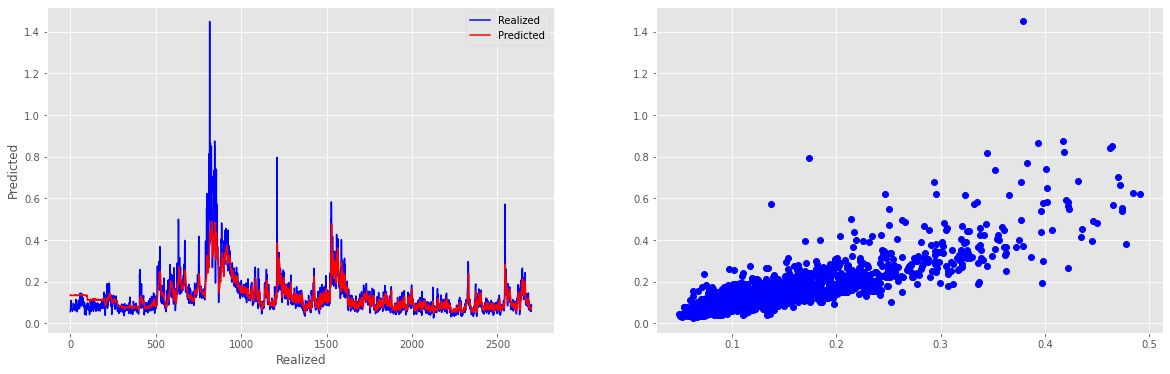

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].set(xlabel="Points", ylabel="Annualized vol")
ax[0].set(xlabel="Realized", ylabel="Predicted")
ax[0].plot(X_full_2, "b", label="Realized")
ax[0].plot(predstot2, "r", label="Predicted");
ax[1].plot(predstot2, X_full_2, 'bo');
ax[0].legend();

- We can see that the flight peaks are not well predicted.

  - In fact, the correct amplitude of the peaks cannot be predicted because the network cannot predict what it does not know. Indeed, on the previous values, no peak of such amplitude is observed.

  - In order to correctly predict these extreme values of volatility, more frequent peaks would be needed, which poses the problem of the window size. But the longer the network is trained, the more extreme values are encountered, which will allow a better estimation of the amplitude of the peaks. 



In [ ]:
# We sotck the last previsions
pd.DataFrame(predstot2).to_csv(".../Predicted_vol_2.csv", index=False, header=False)

---
# 3 - DL + Model

## 1) Adding the predicted volatility in part 1.1

- Here we will add the predictability stored in part 1.1 to our predictor matrix.
- Note that we need to remove the first 501 values of our realized variances because the predicted flights (rv_predict) do not contain them.
- We then use the same architecture to estimate the volatility.

In [ ]:
X_full_log = np.log(spx[["rk_twoscale"]][501:].values)
rv_predict_log = np.log(pd.read_csv(".../Predicted_vol_1.1.csv", header=None).values)

In [ ]:
N_I = 100 # length of sequences input to LSTMs 
X_full_log_sample, y_sample = split_sequence_univariate(X_full_log, N_I)
rv_predict_log_sample, _ = split_sequence_univariate(rv_predict_log, N_I)
X_sample = np.concatenate((X_full_log_sample, rv_predict_log_sample), axis=2)
X_sample.shape

- We run again in the same way as the previous question, keeping the same parameters 

In [ ]:
# Parameters
batch_size=64
neurons_lstm = 100
num_epochs = 20
T_in = batch_size*20 
dT = 100

t1s=np.arange(T_in,X_sample.shape[0]-T_in,dT) 
myLSTM = pred_LSTM(neurons_lstm, batch_size, X_sample.shape) 
predstot3 = np.array([])

for t1 in tqdm(t1s):
  t0 = t1 - T_in
  myLSTM.fit(X_sample[t0:t1], y_sample[t0:t1], batch_size = batch_size, validation_split = 0.2, epochs=num_epochs)
  myLSTM_1 = pred_LSTM(neurons_lstm, dT, X_sample.shape)
  myLSTM_1.set_weights(myLSTM.get_weights())
  preds = myLSTM_1.predict(X_sample[t1:t1+dT],batch_size=dT).flatten()

  predstot3 = np.concatenate((predstot3, preds))

In [ ]:
X_full_3 = np.exp(X_full_log)[N_I + t1s[0]:t1s[-1]+N_I+dT]
predstot3 = np.exp(predstot3)

In [ ]:
X_full_3 = np.sqrt(X_full_3*252)
predstot3 = np.sqrt(predstot3*252)

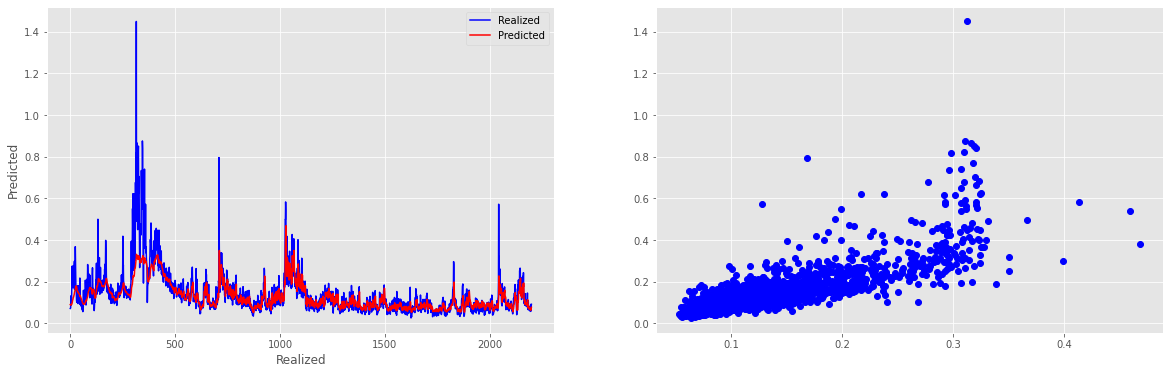

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].set(xlabel="Points", ylabel="Annualized vol")
ax[0].set(xlabel="Realized", ylabel="Predicted")
ax[0].plot(X_full_3, "b", label="Realized")
ax[0].plot(predstot3, "r", label="Predicted");
ax[1].plot(predstot3, X_full_3, 'bo');
ax[0].legend();

- We see that for the first peaks the predictive power is extremely low, but that the following peaks are better estimated (the one around 1000 for example)
- We note that we have less data here,
  - this is due to the fact that the flight_prediction file of the rough model does not contain the first 501 values, and that our first predictions via the LSTM are made from the 1380th data (1280 training calibration window size and 100 timesteps)
  - the network cannot learn as much as in the previous case. 

## 2) Another possibility is to teach the residues $\log(\sigma_{realized}) - \log(\sigma_{rough})$ to the LSTM

- Here we will use as a second feature not the predicted flights but the residuals.

In [ ]:
X_full_log = np.log(spx[["rk_twoscale"]][501:].values)
rv_predict_log = np.log(pd.read_csv(".../Predicted_vol_1.1.csv", header=None).values)

resids = X_full_log - rv_predict_log

In [ ]:
N_I = 100 
X_full_log_sample, y_sample = split_sequence_univariate(X_full_log, N_I)
resids_sample, _ = split_sequence_univariate(resids, N_I)
X_sample = np.concatenate((X_full_log_sample, resids_sample), axis=2)
X_sample.shape

(4694, 100, 2)

- On refait tourner de la même manière que la question précédente, en gardant les mêmes paramètres

In [ ]:
# Parameters
batch_size=64
neurons_lstm = 100
num_epochs = 20
T_in = batch_size*20 
dT = 100

t1s=np.arange(T_in,X_sample.shape[0]-T_in,dT) 
myLSTM = pred_LSTM(neurons_lstm, batch_size, X_sample.shape) 
predstot3_2 = np.array([])

for t1 in tqdm(t1s):
  t0 = t1 - T_in
  myLSTM.fit(X_sample[t0:t1], y_sample[t0:t1], batch_size = batch_size, validation_split = 0.2, epochs=num_epochs)
  myLSTM_1 = pred_LSTM(neurons_lstm, dT, X_sample.shape)
  myLSTM_1.set_weights(myLSTM.get_weights())
  preds = myLSTM_1.predict(X_sample[t1:t1+dT],batch_size=dT).flatten()

  predstot3_2 = np.concatenate((predstot3_2, preds))

In [ ]:
X_full_3_2 = np.exp(X_full_log)[N_I + t1s[0]:t1s[-1]+N_I+dT]
predstot3_2 = np.exp(predstot3_2)

In [ ]:
X_full_3_2 = np.sqrt(X_full_3_2*252)
predstot3_2 = np.sqrt(predstot3_2*252)

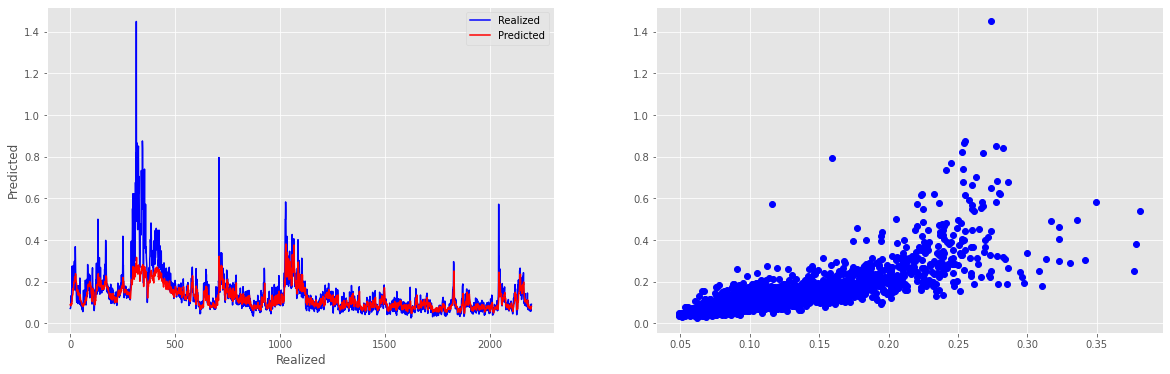

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].set(xlabel="Points", ylabel="Annualized vol")
ax[0].set(xlabel="Realized", ylabel="Predicted")
ax[0].plot(X_full_3_2, "b", label="Realized")
ax[0].plot(predstot3_2, "r", label="Predicted");
ax[1].plot(predstot3_2, X_full_3_2, 'bo');
ax[0].legend();

- In this case, we see that the beginning of the series is much better estimated. The rest of the series is the same or better (the peak around 750 is estimated a little higher than in the previous case).

In [ ]:
pd.DataFrame(predstot3_2).to_csv(".../Predicted_vol_3_2.csv", index=False, header=False)

---
# Other predictors 

- We add the $3^{th}$ Friday of the month as a feature, trying to see if it improves the estimate.

- Indeed, the roll of futures and the expiration of options often takes place on the 3rd Friday of the month, synonymous with strong fluctuations/volatility. We will see if adding the fact that the corresponding timestep day is one of them improves our predictive power, or not.

- We will therefore add a Boolean feature to our last two features (realized variance and predicted variance by rough model).

In [ ]:
from datetime import datetime
def is_third_friday(s):
    """ Function to return if it is the 3rd Friday of the month"""
    d = datetime.strptime(s, '%b %d, %Y')
    return d.weekday() == 4 and 15 <= d.day <= 21

In [ ]:
is_third_frid = spx.index[501:].to_series().apply(lambda x: x.strftime('%b %d, %Y')).apply(is_third_friday).values

- We concatenate the new feature in the same way and estimate the variance

In [ ]:
X_full_log = np.log(spx[["rk_twoscale"]][501:].values)
rv_predict_log = np.log(pd.read_csv(".../Predicted_vol_1.1.csv", header=None).values)

In [ ]:
N_I = 100 
X_full_log_sample, y_sample = split_sequence_univariate(X_full_log, N_I)
resids_sample, _ = split_sequence_univariate(resids, N_I)
is_third_frid, _ = split_sequence_univariate(is_third_frid.reshape(-1, 1), N_I)
X_sample = np.concatenate((X_full_log_sample, resids_sample, is_third_frid), axis=2)
X_sample.shape

(4694, 100, 3)

- We run again in the same way as the previous question, keeping the same parameters

In [ ]:
# Parameters
batch_size=64
neurons_lstm = 100
num_epochs = 20
T_in = batch_size*20 
dT = 100

t1s=np.arange(T_in,X_sample.shape[0]-T_in,dT) 
myLSTM = pred_LSTM(neurons_lstm, batch_size, X_sample.shape) 
predstot4 = np.array([])

for t1 in tqdm(t1s):
  t0 = t1 - T_in
  myLSTM.fit(X_sample[t0:t1], y_sample[t0:t1], batch_size = batch_size, validation_split = 0.2, epochs=num_epochs)
  myLSTM_1 = pred_LSTM(neurons_lstm, dT, X_sample.shape)
  myLSTM_1.set_weights(myLSTM.get_weights())
  preds = myLSTM_1.predict(X_sample[t1:t1+dT],batch_size=dT).flatten()

  predstot4 = np.concatenate((predstot4, preds))

In [ ]:
X_full_4 = np.exp(X_full_log)[N_I + t1s[0]:t1s[-1]+N_I+dT]
predstot4 = np.exp(predstot4)

In [ ]:
X_full_4 = np.sqrt(X_full_4*252)
predstot4 = np.sqrt(predstot4*252)

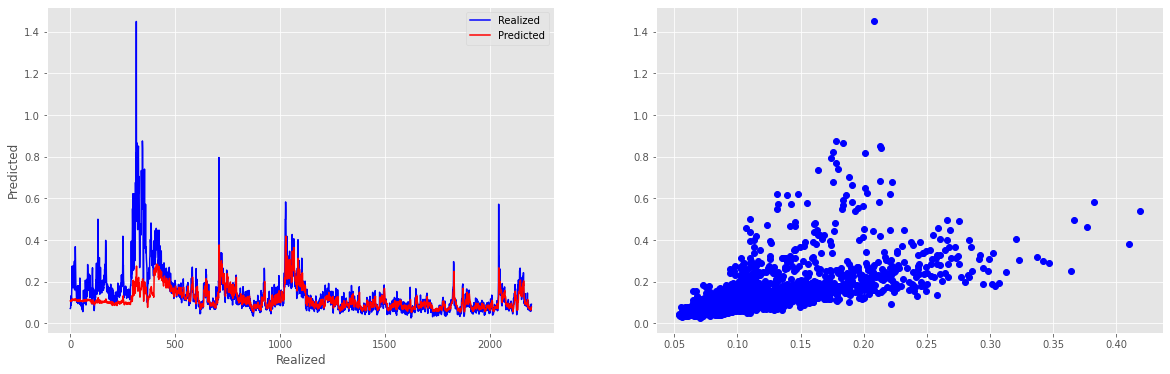

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].set(xlabel="Points", ylabel="Annualized vol")
ax[0].set(xlabel="Realized", ylabel="Predicted")
ax[0].plot(X_full_4, "b", label="Realized")
ax[0].plot(predstot4, "r", label="Predicted");
ax[1].plot(predstot4, X_full_4, 'bo')
ax[0].legend();

- We see that adding the 3rd Friday of the month seems to add predictive power. Let's check it with the comparison.

---
# 4 - Comparison

## RMSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

comparaison = pd.DataFrame(index=["MAE", "RMSE"], columns=["Rough", "LSTM_only", "LSTM+Rough", "LSTM+Rough(resids)", "LSTM+Rough(resids)+IsThirdFriday"])
comparaison.loc["MAE"] = np.array([list(map(mean_absolute_error, [vol_actual, X_full_2, X_full_3, X_full_3_2, X_full_4], [vol_predict, predstot2, predstot3, predstot3_2, predstot4]))])
comparaison.loc["RMSE"] = np.sqrt(np.array([list(map(mean_squared_error, [vol_actual, X_full_2, X_full_3, X_full_3_2, X_full_4], [vol_predict, predstot2, predstot3, predstot3_2, predstot4]))]))

In [ ]:
comparaison

,Rough,LSTM_only,LSTM+Rough,LSTM+Rough(resids),LSTM+Rough(resids)+IsThirdFriday
MAE,0.025735,0.0383822,0.0349844,0.0367229,0.0444952
RMSE,0.0432204,0.076798,0.0694057,0.0752848,0.0897288


- Unsurprisingly the rough volatility model is the best model from a predictive point of view. 

- From a Deep Learning point of view, we can see that :
  - LSTM + rough model is better than LSTM alone
  - learning residuals instead of the predicted variance does not decrease the error rate
  - adding the third Friday of the month boolean does not add any predictive power.

- We therefore verify that using deep learning with the help of models is one of the best approaches.